# RK4RC Temporal Subsampling with mixed Macro Cost

RK4 shows no benefit...

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

from ddc import YAMLParser
from sqgtools import XSQGTurb, SpectrumPlotter

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, BigPlot, plot_ke_relerr

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
class RK4RCDataset(RCDataset):
    def get_results_path(self, cost, n_sub):
        
        main_dir = "cost-rk4-"
        main_dir += "-".join(f"{k}{v:1.1e}" for k,v in cost.items())
        
        dt0=300
        delta_t = n_sub*dt0
        out_dir = f"/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/rc-temporal-sampling-064n/{main_dir}/"
        out_dir += f"validation-{delta_t:04d}dt-{self.n_samples:03d}samples/"
        fname = out_dir + "results.zarr"
        return main_dir, fname
    
    def open_single_dataset(self, this_cost, n_sub):
        main_dir, fname = self.get_results_path(this_cost, n_sub)

        try:
            xds = xr.open_zarr(fname, chunks=self.chunks)
        except:
            xds = xr.concat(
                    [xr.open_zarr(fname.replace("results", f"results.{i:03d}"), chunks=self.chunks) for i in range(self.n_samples)],
                    dim="sample",
                    coords="minimal")

        xds = self.renormalize_dataset(xds, fname)
        experiment = main_dir.replace("cost-rk4-","")
        xds = xds.expand_dims({
            'n_sub': [n_sub],
            'experiment': [experiment]
        })
        return xds

In [6]:
rcd = RK4RCDataset(
    n_sub=[16],
    cost_terms = [
        {"nrmse": 1},
        {"nrmse": 1, "spectral": 0.0001},
        {"nrmse": 1, "spectral": 0.001},
        {"nrmse": 1, "spectral": 0.01},
        # this one is just shit
        #{"nrmse": 1, "global-integral": 0.0001},
    ]
)

In [7]:
ds = rcd()

Grab one sample for some plotting

In [8]:
xds = ds.sel(sample=2,
             experiment=['nrmse1.0e+00',
                         'nrmse1.0e+00-spectral1.0e-04',
                         'nrmse1.0e+00-spectral1.0e-03',
                         'nrmse1.0e+00-spectral1.0e-02',
                        ])

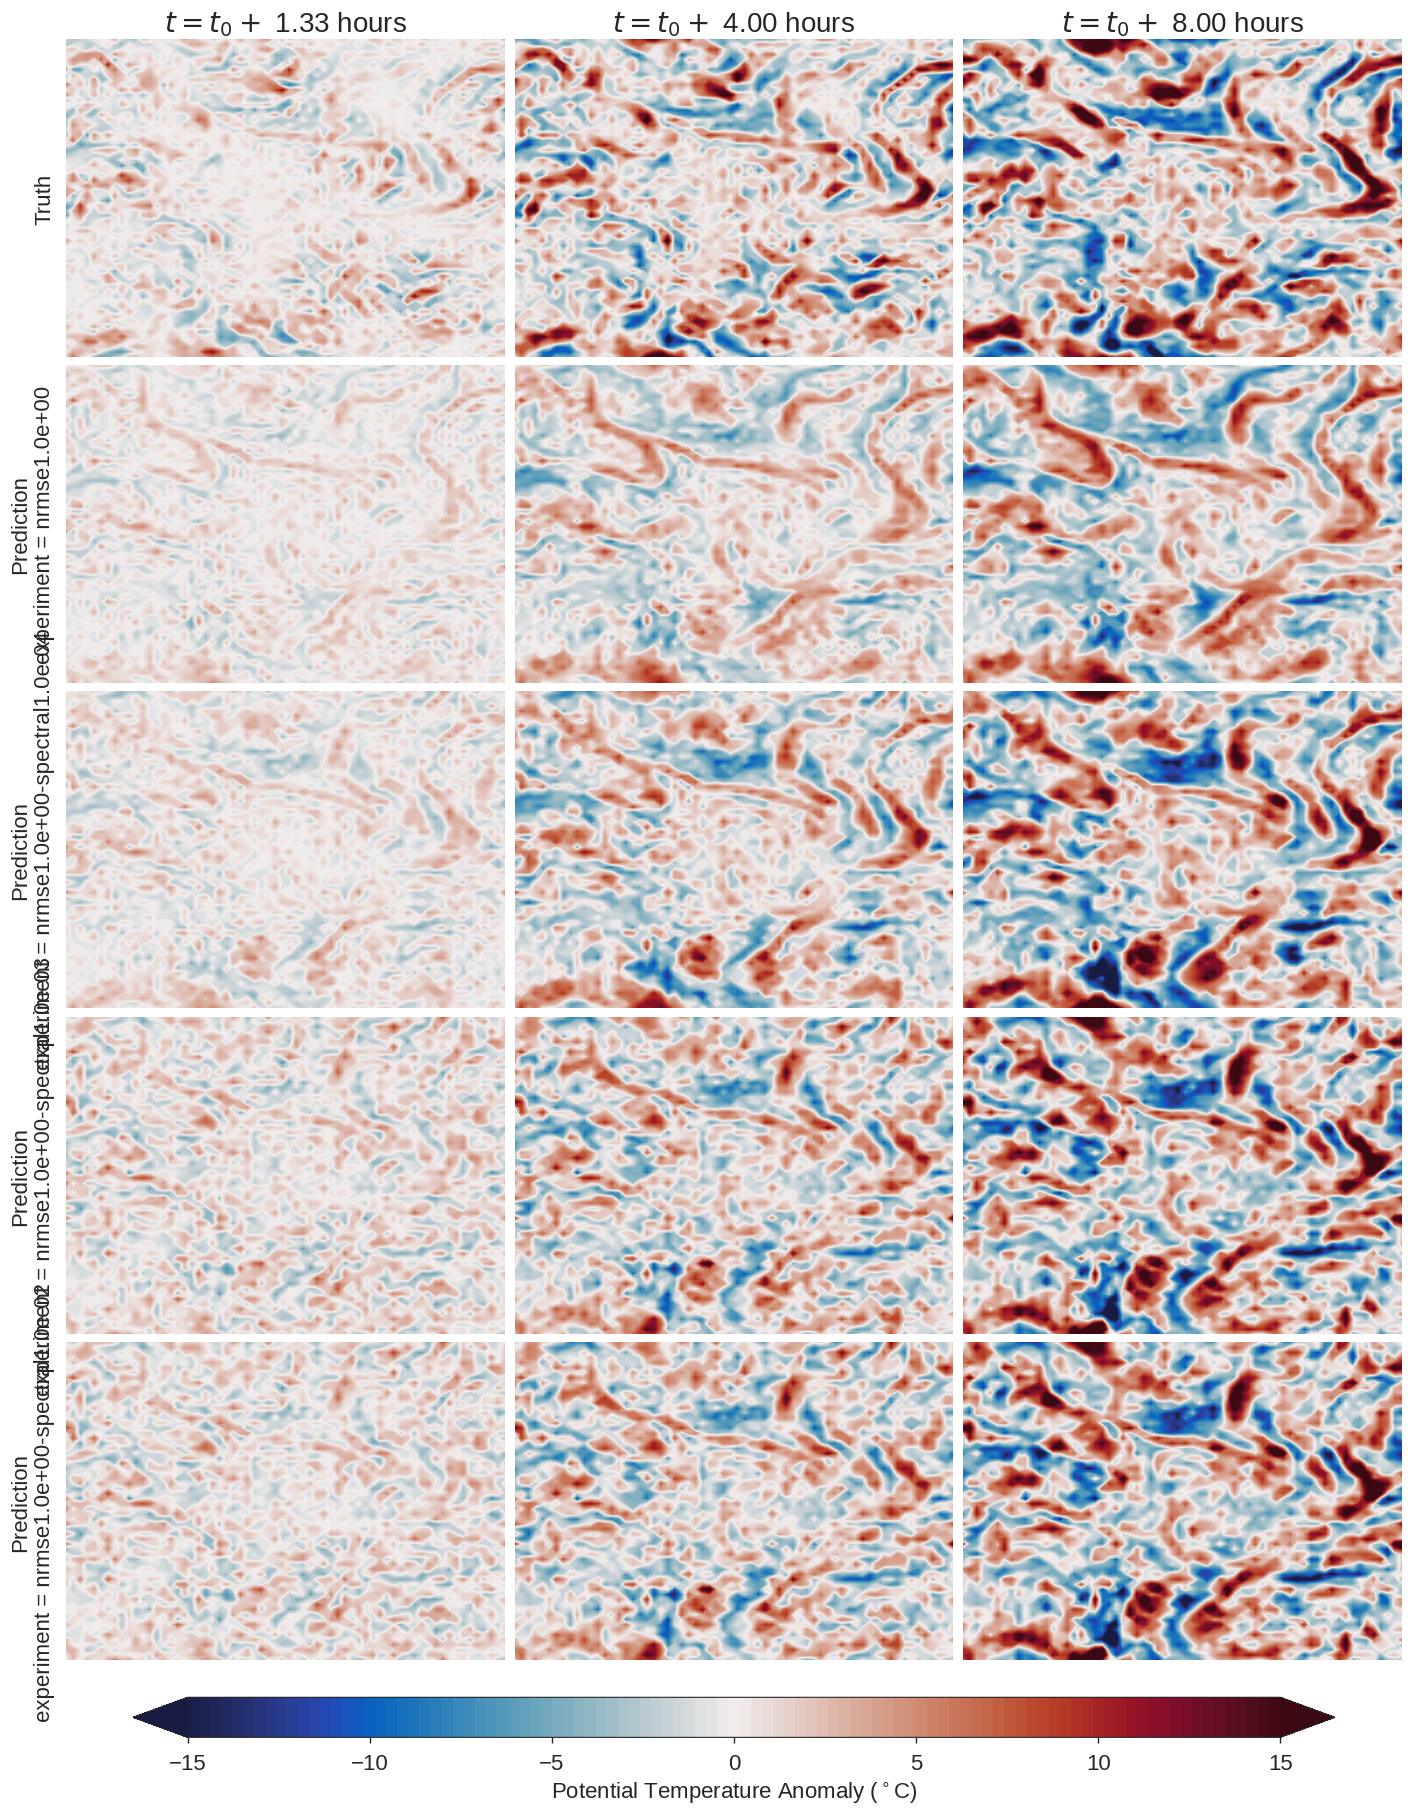

In [9]:
bp = BigPlot()
fig, axs = bp(xds, row_dim="experiment")

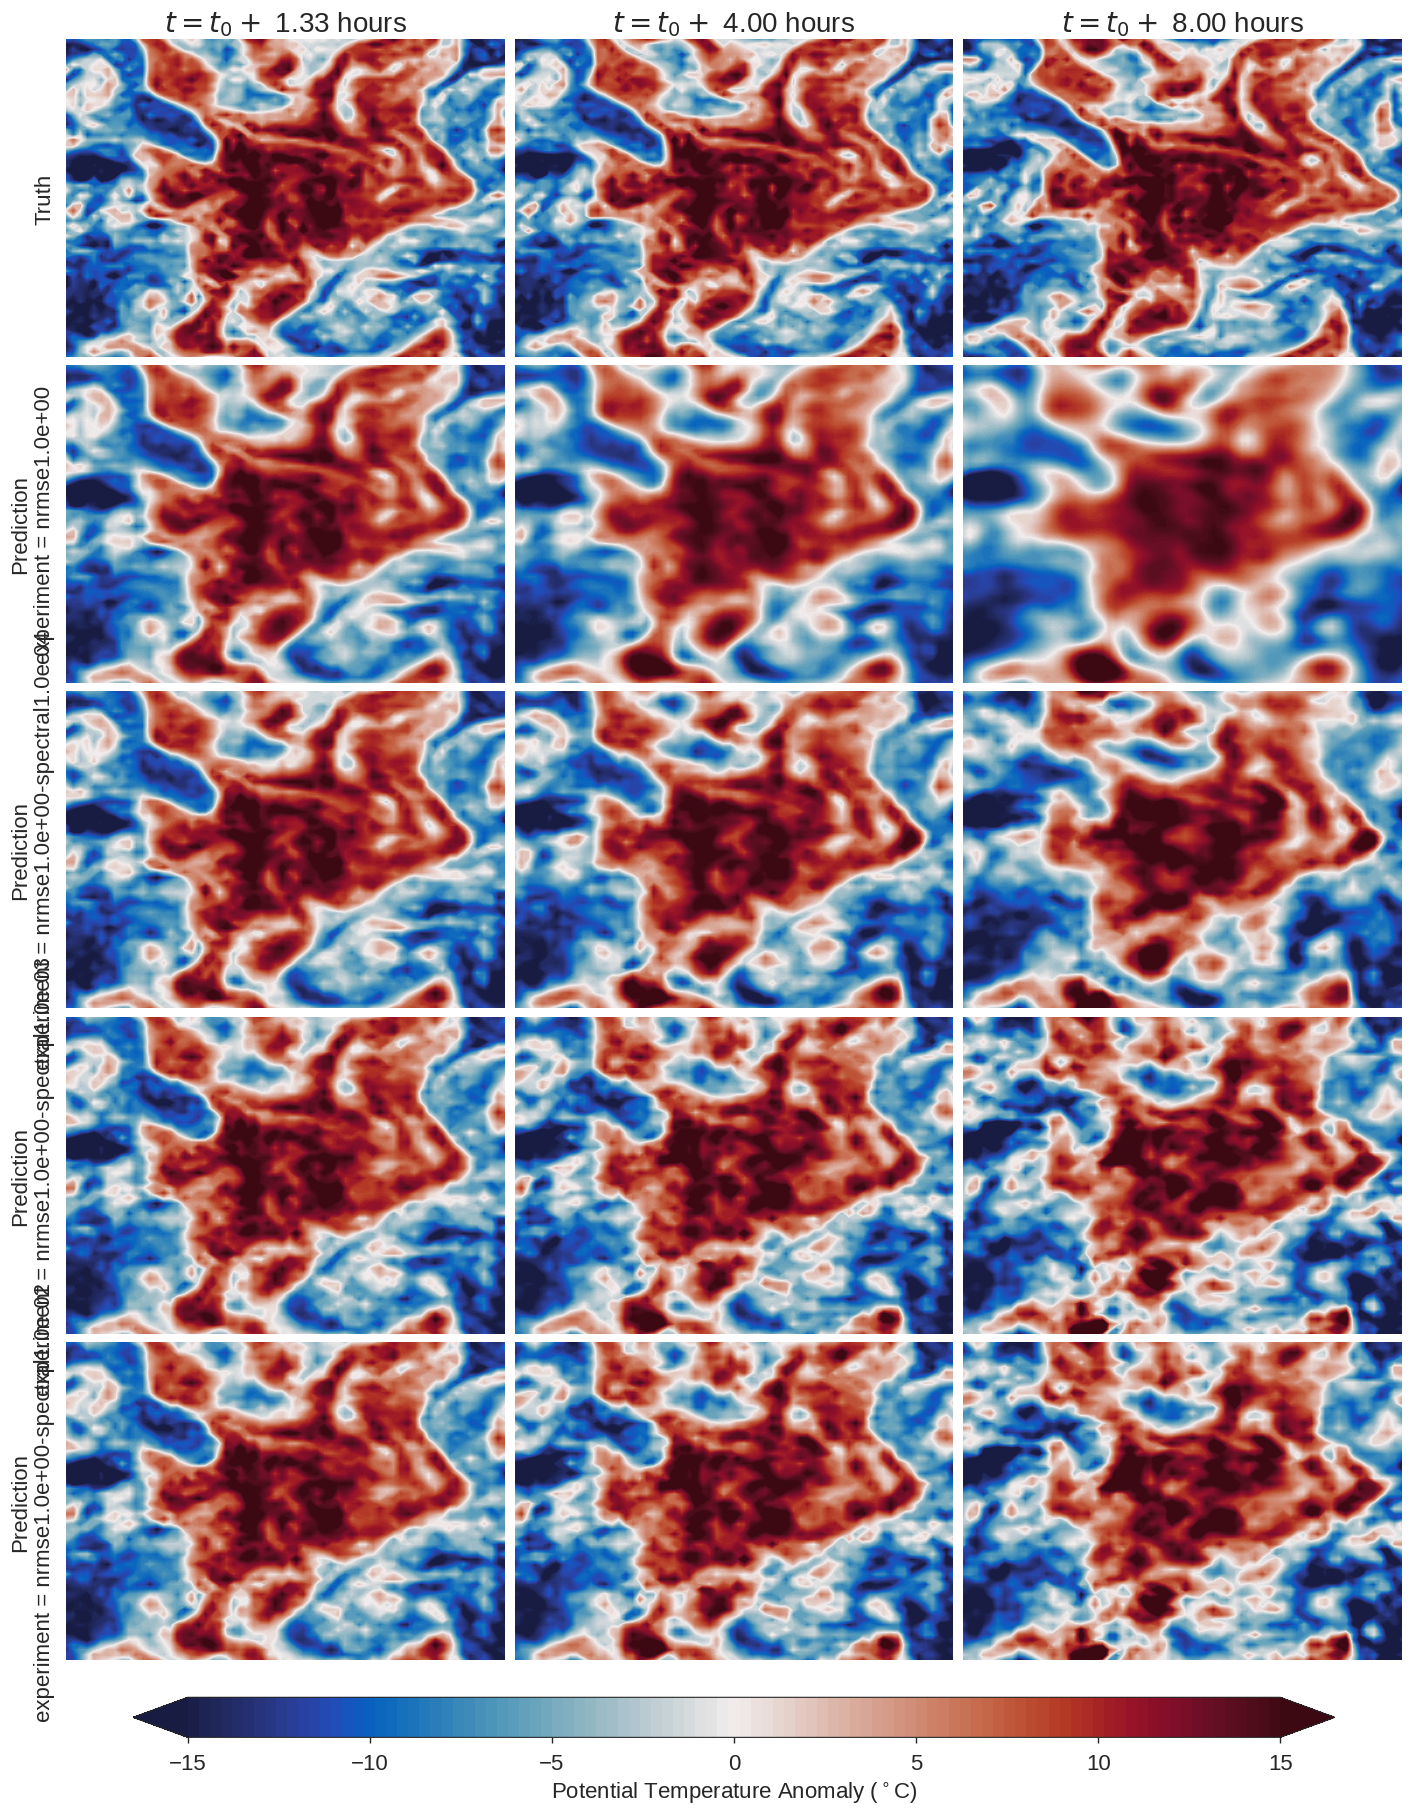

In [10]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds, row_dim="experiment")

In [11]:
ep = BigPlot(prediction="absolute_error",
             cbar_label=r"Absolute Error ($^\circ C$)",
             cmap="viridis",
             plot_truth=False,
             vmax=10,
             vmin=0,
             subplot_kw={
                 "figsize":(14,14),
                 "constrained_layout": True,
             }
            )

In [12]:
#fig, axs = ep(xds, row_dim="experiment")

## NRMSE, ACC

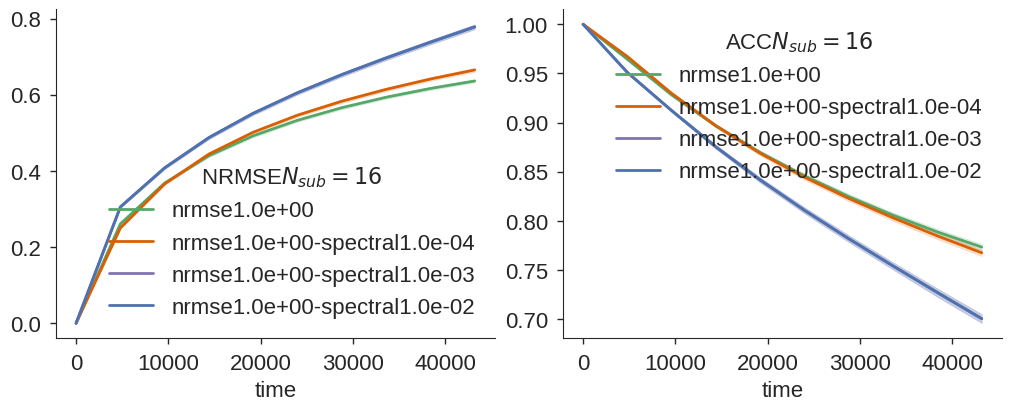

In [13]:
nrows = 1
ncol = len(xds.experiment)
fig, axs = plt.subplots(nrows, 2, figsize=(10,4*nrows), sharex=True, constrained_layout=True)

n_sub=16

for metric, ax in zip(["nrmse", "acc"], axs):
    for experiment in ds.experiment.values:
        plotme = ds.sel(experiment=experiment)
        plotme = plotme[metric].to_dataset()
        df = plotme.to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="time",
            y=metric,
            ax=ax,
            label=experiment,
        )
    ax.set(ylabel="")
    ax.legend(title=xds[metric].label + r"$N_{sub} = %d$" % n_sub)

## Spectra

In [14]:
time = np.array([1.3333, 4, 8, 12])*3600
xds = ds.sel(time=time,method="nearest")

In [15]:
xsqg = XSQGTurb()
ktrue = xsqg.calc_kespec1d(xds["truth"].load())
kpred = xsqg.calc_kespec1d(xds["prediction"].load())

In [16]:
kerr = kpred - ktrue
relerr = np.abs(kerr/ktrue)

In [18]:
def exp_label(exp):
    split = exp.split("-spectral")
    alpha = split[0].split("nrmse")[-1]
    beta = 0 if len(split)==1 else split[1].split("spectral")[-1]
    
    alpha = int(np.log10(float(alpha)))
    beta = float(beta)
    beta = int(np.log10(beta)) if beta != 0 else -16
    
    return r"$\alpha = 10^{%d}, \beta = 10^{%d}$" % (alpha, beta)

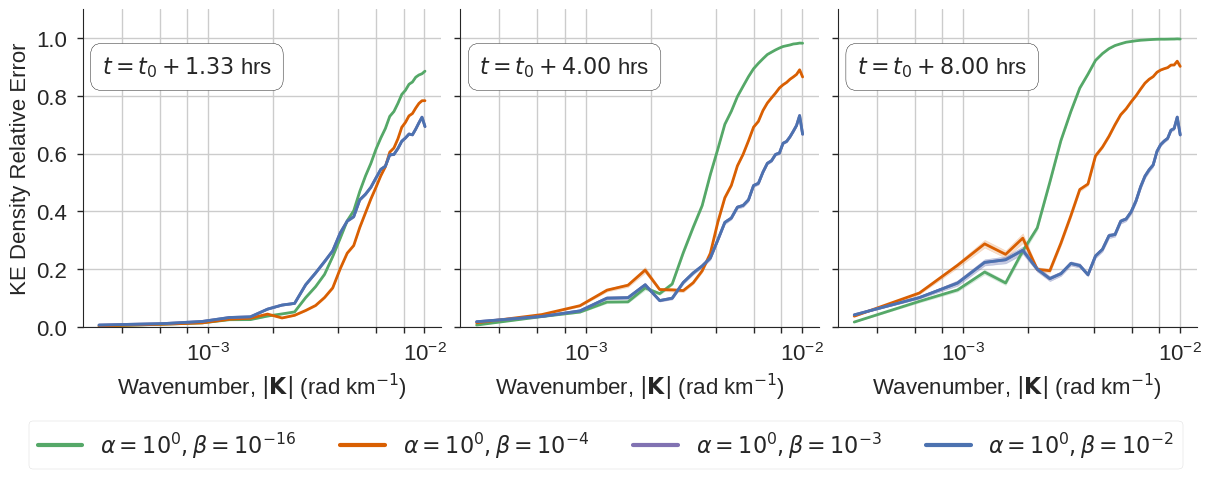

In [19]:
fig, axs = plot_ke_relerr(relerr, errorbar="ci", cdim="experiment", clabel=exp_label)

Not really an improvement over standard RC.